In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.sql import text

import baikalfunctions as bfunc
import scheme_mar2023 as scheme
import mytools

In [2]:
# pd.set_option('display.min_rows', 100)
%matplotlib inline
plt.style.use('dark_background')   # try another styles: 'classic'
plt.rcParams['figure.figsize'] = [15, 5]
#plt.subplots_adjust(top=1, left=0, right=1, bottom=0)

In [3]:
saveImgPath = 'C:\\xampp\\htdocs\\img\\'

In [4]:
# host = 192.168.3.53
host = 'localhost'
tableName = "jun2023sea"

engine = create_engine(f"mysql+pymysql://root:oceana1777@{host}:3306/baikal")
#req = f"select * from {tableName} where DateTime > ADDDATE((SELECT DATETIME FROM {tableName} ORDER BY " \
#      f"DATETIME DESC LIMIT 1), INTERVAL -24 hour);"
req = f"select * from {tableName}"

In [5]:
with engine.connect().execution_options(autocommit=True) as conn:
    query = conn.execute(text(req))
df = pd.DataFrame(query.fetchall())
df.head(5)

,DateTime,Comments,SPEED,SPEED_err,COURSE,COURSE_err,V1_state,V1_state_err,V2_state,V2_state_err,...,KFA_R,KFA_R_err,NX_G,NX_G_err,NX_B,NX_B_err,KFA_B,KFA_B_err,KFA_G,KFA_G_err
0,2023-06-04 20:31:20,None,0.415067,0.102208,0.00000,0.0000,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-04 20:31:00,None,0.413071,0.047104,3.12643,11.2725,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-04 20:30:40,None,0.352125,0.065053,2.87313,11.1276,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-04 20:30:20,None,0.409286,0.117703,9.11786,17.4763,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-04 20:30:00,None,0.418813,0.101501,2.73625,10.5975,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.shape

(22025, 74)

In [7]:
df.rename(columns=scheme.NAME_CONV_BAS, inplace=True)
df.sort_values(by='DateTime', inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(2)

,DateTime,Comments,Speed,SPEED_err,Course,COURSE_err,V1_state,V1_state_err,V2_state,V2_state_err,...,FluoKfaRed,KFA_R_err,FluoNxGrn,NX_G_err,FluoNxBlu,NX_B_err,FluoKfaBlu,KFA_B_err,FluoKfaGrn,KFA_G_err
0,2023-06-04 15:59:20,None,4.27800,0.076581,27.8433,0.571625,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-04 15:59:40,None,4.26238,0.067269,27.7414,1.118570,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
with engine.connect().execution_options(autocommit=True) as con:
    dft = pd.read_sql_table('jun2023sea_t', con, index_col='index')

In [9]:
df.shape, dft.shape

((22025, 74), (19656, 28))

In [10]:
df = pd.concat([df, dft])
df.sort_values(by='DateTime', inplace=True)
df.reset_index(inplace=True, drop=True)

In [11]:
df.drop([x for x in df.columns if x.lower().endswith('err')], axis='columns', inplace=True, errors='ignore')
df.drop([x for x in df.columns if x.lower().startswith('pump')], axis='columns', inplace=True, errors='ignore')


In [12]:
df.shape, df.columns

((41681, 37),
 Index(['DateTime', 'Comments', 'Speed', 'Course', 'V1_state', 'V2_state',
        'V3_state', 'V4_state', 'V5_state', 'V6_state', 'V7_state', 'V8_state',
        'AirFlow', 'TempAir', 'PressAir', 'Precipitation', 'LightLX', 'LightUV',
        'Latitude', 'Longitude', 'WaterFlowEqu1', 'WaterFlowEqu2',
        'WaterFlowEqu3', 'TempEqu1', 'TempEqu2', 'TempEqu3', 'EKV_4_TEMP',
        'vCO2', 'vCH4', 'vH2O', 'FluoNxRed', 'FluoKfaRed', 'FluoNxGrn',
        'FluoNxBlu', 'FluoKfaBlu', 'FluoKfaGrn', 'Channel'],
       dtype='object'))

In [13]:
## gether/apply specific variables
### data corrections
df['vCO2'] = df['vCO2'] * scheme.CO2PicarroScaut_cor[0] + scheme.CO2PicarroScaut_cor[1]
df['vCH4'] = df['vCH4'] * scheme.CH4PicarroScaut_cor[0] + scheme.CH4PicarroScaut_cor[1]
df['LightLX'] = df['LightLX'] * scheme.solar_cor[0] + scheme.solar_cor[1]
df['LightUV'] = df['LightUV'] * scheme.solar_uv_cor[0] + scheme.solar_uv_cor[1]
df['PressAir'] = bfunc.pressConvert(df['PressAir'])
df['PressAir'] = df['PressAir'] * scheme.press_cor[0] + scheme.press_cor[1]

### servise data corrections
df['TempEqu1'] = df['TempEqu1'] * scheme.tempEqu1_cor_m[0] + scheme.tempEqu1_cor_m[1]
df['TempEqu2'] = df['TempEqu2'] * scheme.tempEqu2_cor_m[0] + scheme.tempEqu2_cor_m[1]
df['TempEqu3'] = df['TempEqu3'] * scheme.tempEqu3_cor_m[0] + scheme.tempEqu3_cor_m[1]

df['AirFlow'] = df['AirFlow'] * scheme.airflow_cor_m[0] + scheme.airflow_cor_m[1]
df['WaterFlowEqu1'] = df['WaterFlowEqu1'] * scheme.waterflowEqu1_cor_m[0] + scheme.waterflowEqu1_cor_m[1]
df['WaterFlowEqu2'] = df['WaterFlowEqu2'] * scheme.waterflowEqu2_cor_m[0] + scheme.waterflowEqu2_cor_m[1]
df['WaterFlowEqu3'] = df['WaterFlowEqu3'] * scheme.waterflowEqu3_cor_m[0] + scheme.waterflowEqu3_cor_m[1]

In [14]:
v_state_list = list(scheme.CHANNEL_COLS.values())

chnl = 'Channel'
if not chnl in df.columns:
    df[chnl] = 0
if 'V1_state' in df.columns:
    df.loc[df.V1_state == 1, chnl] = 1
    df.loc[df.V2_state == 1, chnl] = 2
    df.loc[df.V3_state == 1, chnl] = 3
    df.loc[df.V4_state == 1, chnl] = 4
    df.loc[df.V5_state == 1, chnl] = 5
    df.loc[df.V6_state == 1, chnl] = 6
df.drop(v_state_list, axis='columns', inplace=True, errors='ignore')

In [15]:
ch_v = 'Chn_valid'
df[ch_v] = 1
for deep in range(1, 7):
    df.loc[df[chnl] != df[chnl].shift(deep), ch_v] = 0

<Axes: xlabel='DateTime', ylabel='vCO2'>

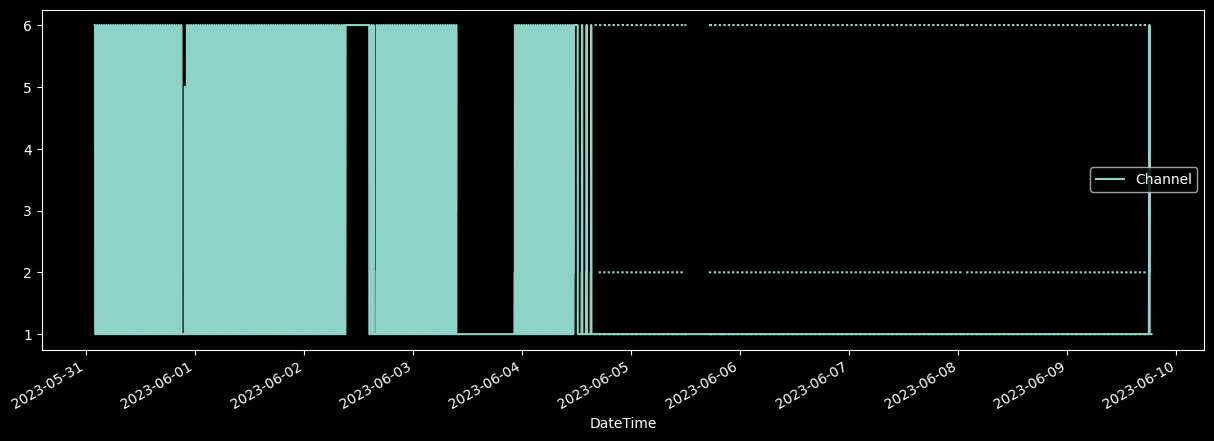

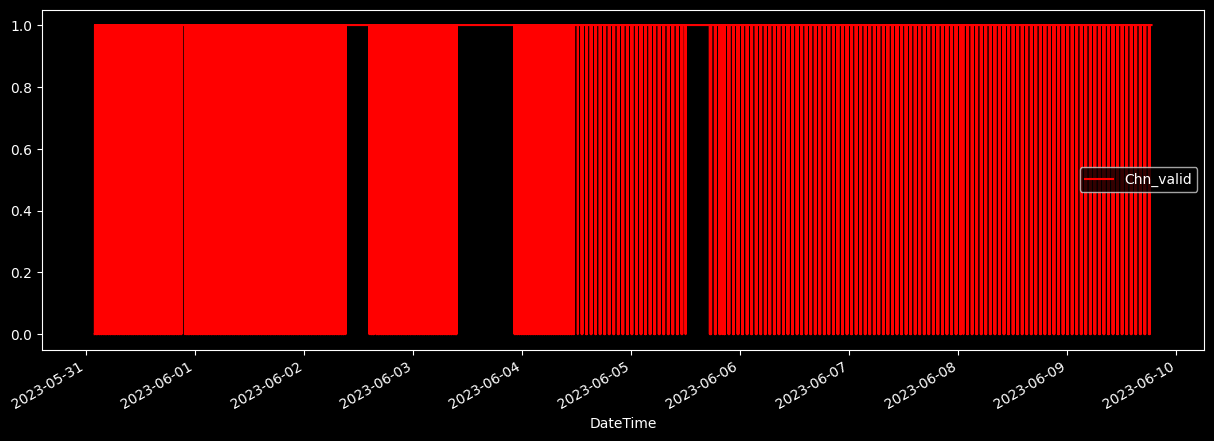

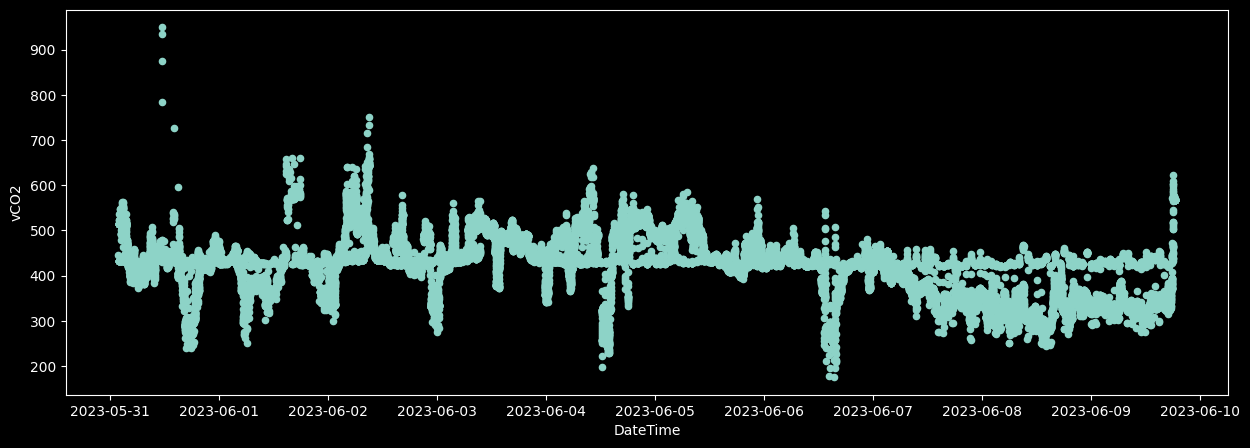

In [16]:
df.plot('DateTime', 'Channel')
df.plot('DateTime', 'Chn_valid', c='red')
df.plot('DateTime', 'vCO2', kind='scatter')

In [17]:
df.columns

Index(['DateTime', 'Comments', 'Speed', 'Course', 'AirFlow', 'TempAir',
       'PressAir', 'Precipitation', 'LightLX', 'LightUV', 'Latitude',
       'Longitude', 'WaterFlowEqu1', 'WaterFlowEqu2', 'WaterFlowEqu3',
       'TempEqu1', 'TempEqu2', 'TempEqu3', 'EKV_4_TEMP', 'vCO2', 'vCH4',
       'vH2O', 'FluoNxRed', 'FluoKfaRed', 'FluoNxGrn', 'FluoNxBlu',
       'FluoKfaBlu', 'FluoKfaGrn', 'Channel', 'Chn_valid'],
      dtype='object')

In [18]:
df['vCO2air'] = df['vCO2'][(df[chnl] == 6) & (df[ch_v] == 1)]
df['vCH4air'] = df['vCH4'][(df[chnl] == 6) & (df[ch_v] == 1)]
df['vCO2air'].fillna(method='ffill', axis='index', inplace=True)
df['vCH4air'].interpolate(method='values', inplace=True)  ## `time` method mb better
df['pCO2air'] = df['vCO2air'] * df['PressAir']  # mkatm
df['pCH4air'] = df['vCH4air'] * df['PressAir']  # mkatm

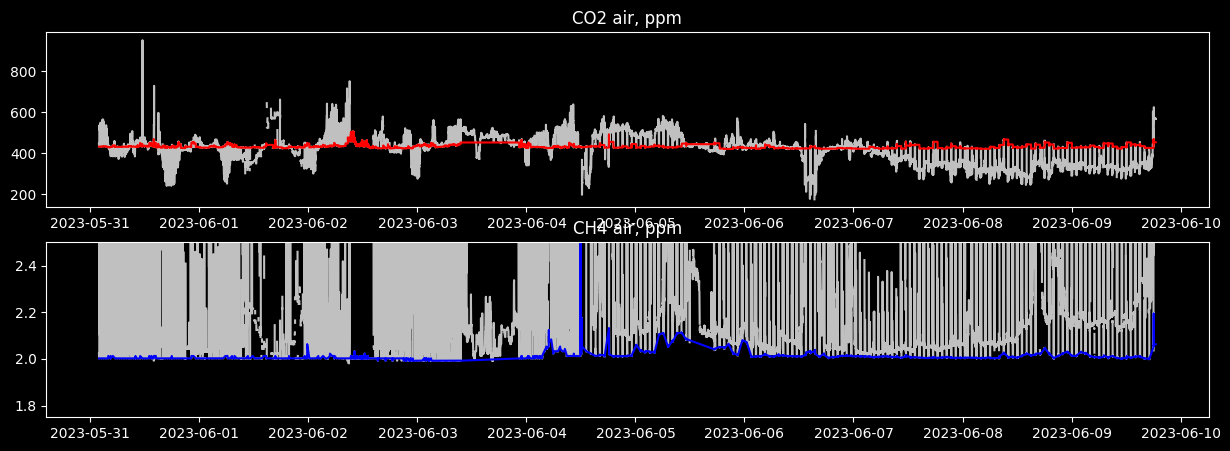

In [19]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(2, 1)

axs[0].set_title('CO2 air, ppm')
axs[0].plot(df.DateTime, df['vCO2'], '-', c='silver')
axs[0].plot(df.DateTime, df['vCO2air'], 'r-')

axs[1].set_title('CH4 air, ppm')
axs[1].set_ylim(1.75, 2.5)
axs[1].plot(df.DateTime, df['vCH4'], '-', c='silver')
axs[1].plot(df.DateTime, df['vCH4air'], 'b-')
fig.savefig(saveImgPath+'cAir_vs_time.png', transparent=False)

In [20]:
## RECOVERY HERE !!!
equ_vol = scheme.equ_seatube_param['equ_vol']  # equivalent equ volume, l
equ_cap = scheme.equ_seatube_param['equ_cap']  # equilibrator capacity
df['DateSec'] = df['DateTime'].astype('int64')//10**9
df['dTSec'] = df['DateSec'] - df['DateSec'].shift(1)
dt = df['dTSec'] / 60   ## delta time, min
t_wtr = df['TempEqu1']
t_air = t_wtr
air_flow = df['AirFlow']
wtr_flow = df['WaterFlowEqu1']

In [21]:
### CO2 water
df['vCO2equ1'] = df['vCO2'][(df[chnl] == 1) & (df[ch_v] == 1)]
solubility = bfunc.getSolubility(df['TempEqu1'], 'CO2')

density = bfunc.getDensity(t_air, df['PressAir'], 'CO2')
cGasAir = df['pCO2air'] / 1000000 * density
pGasEquAir = df['vCO2equ1'] * df['PressAir']
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)

df['cCO2wtr'] = cGasWtr * 1000     # mg/l
df['pCO2wtr'] = cGasWtr * 1000000 / solubility  # mkatm

In [22]:
### CH4 water
df['vCH4equ1'] = df['vCH4'][(df[chnl] == 1) & (df[ch_v] == 1)]
solubility = bfunc.getSolubility(df['TempEqu1'], 'CH4')

density = bfunc.getDensity(t_air, df['PressAir'], 'CH4')
cGasAir = df['pCH4air'] / 1000000 * density
pGasEquAir = df['vCH4equ1'] * df['PressAir']
cGasEquAir = pGasEquAir * density / 1000000  # g/l

tau = equ_vol/(air_flow+wtr_flow*equ_cap*solubility/density)
eternal = (cGasEquAir-cGasEquAir.shift(1)*np.exp(-1*dt/tau))/(1-np.exp(-1*dt/tau))
cGasWtr = (eternal*(wtr_flow*equ_cap*solubility/density+air_flow)-air_flow*cGasAir)/(wtr_flow*equ_cap)
df['cCH4wtr'] = cGasWtr * 1000000000    # ng/l
df['pCH4wtr'] = cGasWtr * 1000000 / solubility  # mkatm

In [23]:
for col in ['cCO2wtr', 'pCO2wtr', 'cCH4wtr', 'pCH4wtr']:
    df.loc[df[col] == np.inf , col] = np.nan 
    df.loc[df[col] == -np.inf , col] = np.nan
    # df.loc[df[col] <= 0 , col] = np.nan

df['pCO2wtr'].describe()

count    26046.000000
mean       382.600257
std        104.556028
min      -1662.627012
25%        294.685073
50%        398.185900
75%        455.064958
max       4895.089777
Name: pCO2wtr, dtype: float64

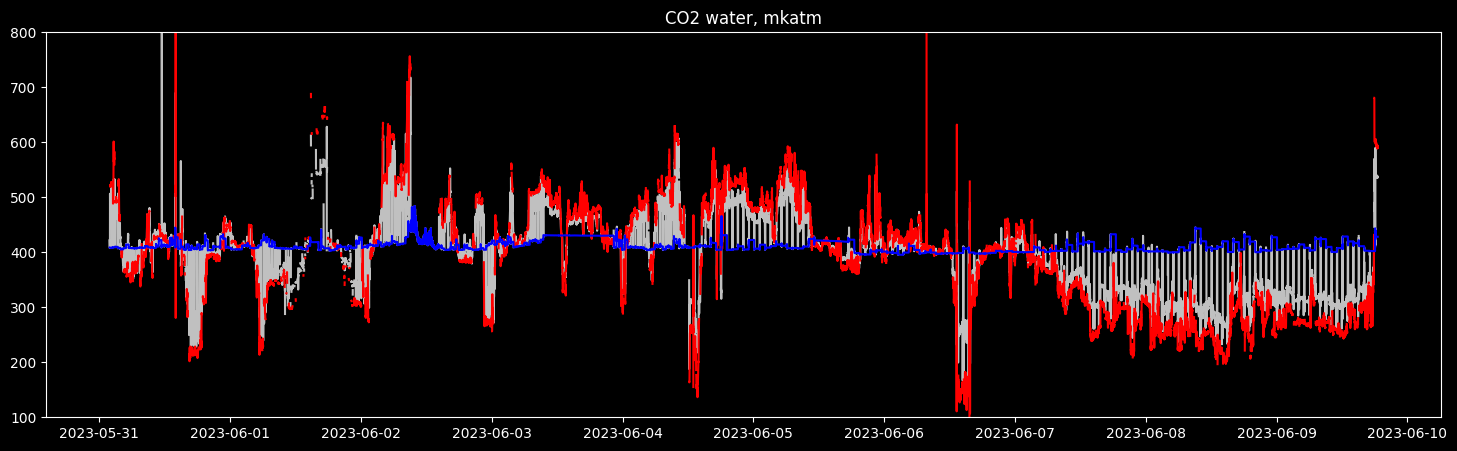

In [24]:
df['pCO2'] = df['vCO2'] * df['PressAir']

plt.rcParams['figure.figsize'] = [18, 5]
fig, ax = plt.subplots()
## ax.set_xlim(pd.to_datetime('05.06.2023 18:00:00', dayfirst=True), pd.to_datetime('05.06.2023 19:00:00', dayfirst=True))
ax.set_title('CO2 water, mkatm')
ax.set_ylim(100, 800)
ax.plot(df.DateTime, df['pCO2'], '-', c='silver')
ax.plot(df.DateTime, df['pCO2wtr'], 'r-')
ax.plot(df.DateTime, df['pCO2air'], 'b-')
fig.savefig(saveImgPath+'pCO2wtr_vs_time.png')

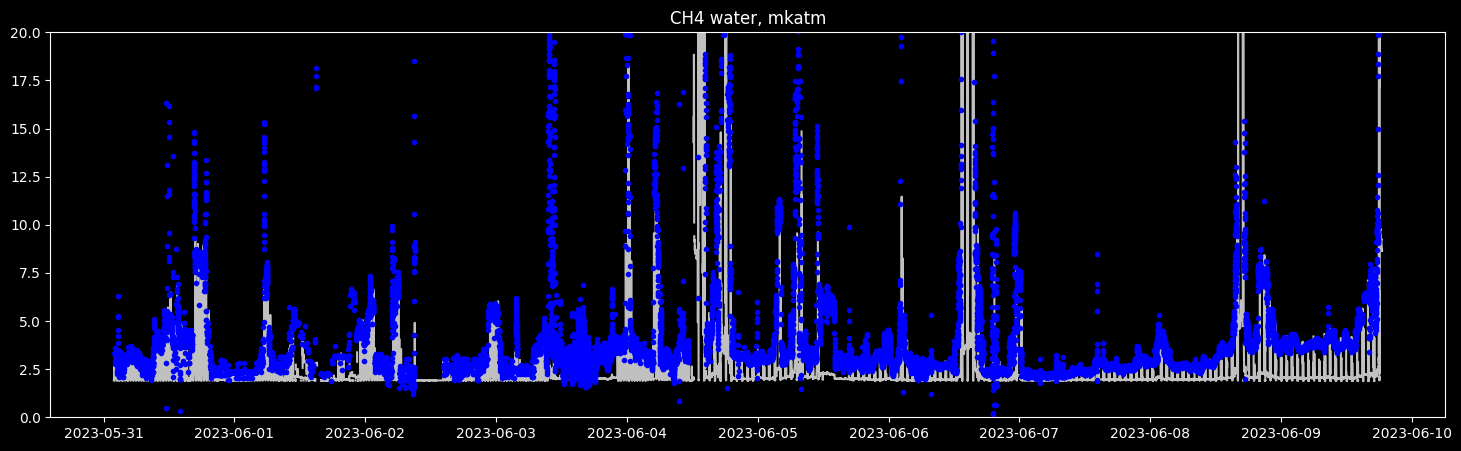

In [25]:
df['pCH4'] = df['vCH4'] * df['PressAir']

plt.rcParams['figure.figsize'] = [18, 5]
fig, ax = plt.subplots()
ax.set_title('CH4 water, mkatm')
# ax.set_xlim(pd.to_datetime('06.06.2023 10:00:00', dayfirst=True), pd.to_datetime('06.06.2023 19:00:00', dayfirst=True))
ax.set_ylim(0, 20)
ax.plot(df.DateTime, df['pCH4'], '-', c='silver')
ax.plot(df.DateTime, df['pCH4wtr'], 'b.')
fig.savefig(saveImgPath+'pCH4wtr_vs_time.png')

In [26]:
obrisData = "G:/1_Data1/obris/obris.dat"
obris = pd.read_csv(obrisData,
                    header=0,
                    na_values='--',
                    sep='\t',
                    decimal=',',
                    )
obris.head(3)

,i,long,lat
0,1,NaN,NaN
1,2,109.004,53.667
2,3,109.008,53.665


In [27]:
allMethaneData = "G:/1_Data1/sea/AllSeaGisOut.txt"
colNames = ['i', 'long', 'lat', 'cCH4wtr']
allMethane_df = pd.read_csv(allMethaneData,
                            index_col =0,
                            sep='\t',
                            skiprows=[0, 1, 2],
                            usecols=[0, 1, 2, 3],
                            header=None,
                            names=colNames,
                           )
allMethane_df.head(5)

,long,lat,cCH4wtr
i,,,
0,103.75,51.695,120.548499
1,103.76,51.690,123.197871
2,103.76,51.695,114.449653
3,103.77,51.690,119.207194
4,103.77,51.695,107.322251


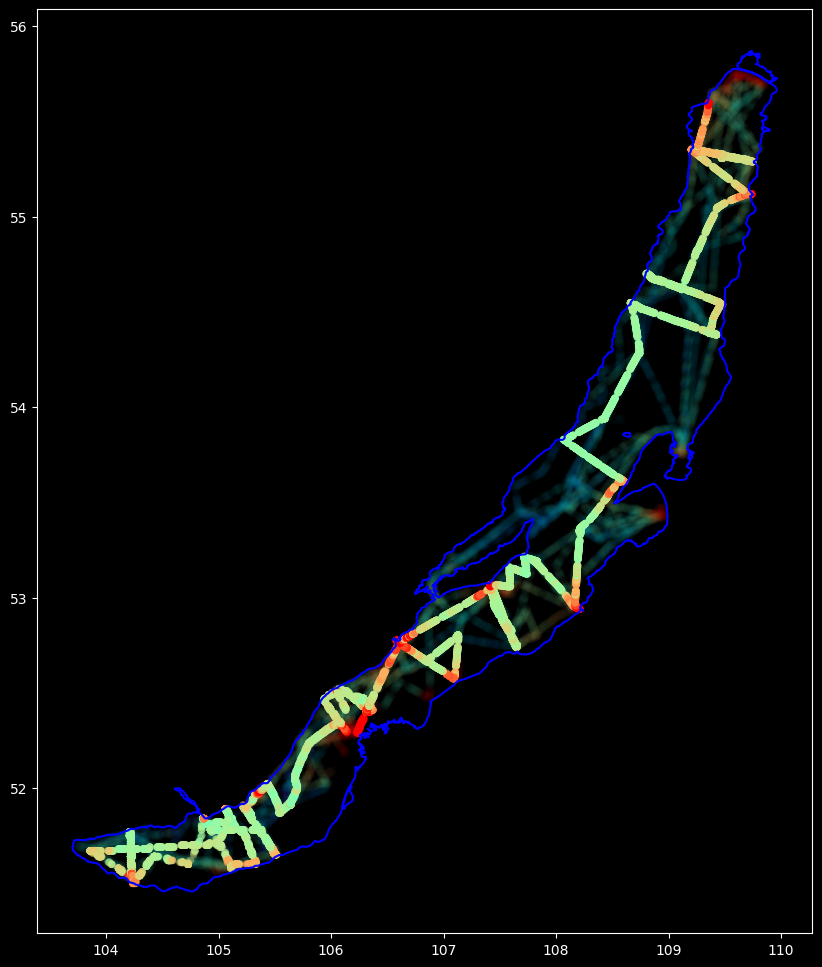

In [28]:
cCH2lim_top = 700
df.loc[df.cCH4wtr > cCH2lim_top, 'cCH4wtr'] = cCH2lim_top
allMethane_df.loc[allMethane_df.cCH4wtr > cCH2lim_top, 'cCH4wtr'] = cCH2lim_top
cCH2lim_bot = 0
df.loc[df.cCH4wtr < cCH2lim_bot, 'cCH4wtr'] = np.NaN
allMethane_df.loc[allMethane_df.cCH4wtr < cCH2lim_bot, 'cCH4wtr'] = np.NaN

df.dropna(axis='index', subset=['Longitude', 'Latitude', 'cCH4wtr'], inplace=True)


cCH4wtrlog_all = np.log(allMethane_df['cCH4wtr'])
cCH4wtrlog = np.log(df['cCH4wtr'])

plt.rcParams['figure.figsize'] = [10, 12]
fig, ax = plt.subplots()
#ax.set_xlim(106.2, 109.4)
#ax.set_ylim(52, 55)

ax.plot(obris['long'], obris['lat'], 'b-')
ax.scatter(x='long', y='lat', c=cCH4wtrlog_all, s=50, marker='o', linewidth=0, cmap='rainbow', alpha=0.02, data=allMethane_df, )
ax.scatter(df['Longitude'], df['Latitude'], c=cCH4wtrlog, s=30, marker='o', linewidth=0, cmap='rainbow', alpha=0.4,)
fig.savefig(saveImgPath+'CH4wtrSpatialJun2023.png', transparent=True)


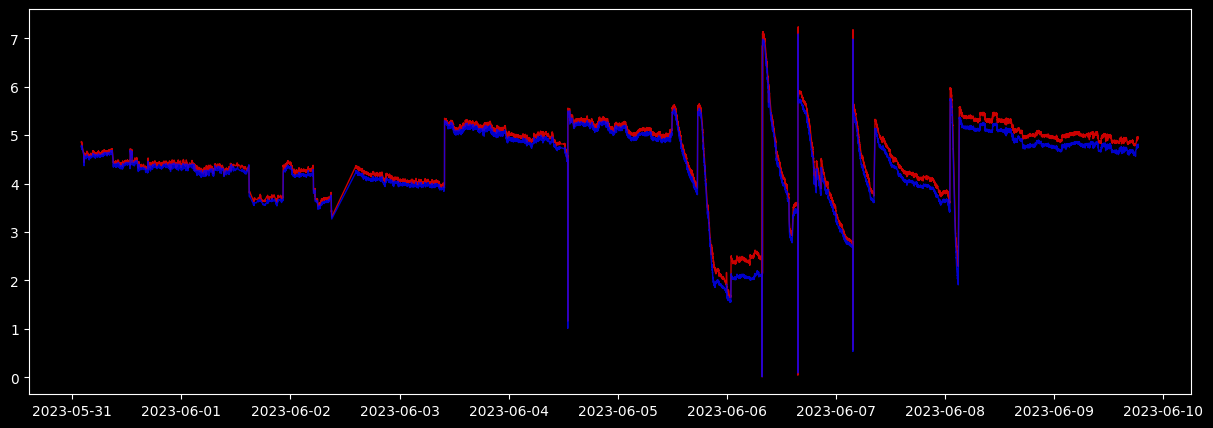

In [29]:
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax = plt.subplots()

ax.plot('DateTime', 'WaterFlowEqu1', 'r-', linewidth=1, alpha=0.8, data=df, )
ax.plot('DateTime', 'WaterFlowEqu2', 'b-', linewidth=1, alpha=0.8, data=df, )
fig.savefig(saveImgPath+'sWaterFlow.png')


In [30]:
df.cCH4wtr.dropna().describe()

count    25111.000000
mean       168.161576
std        140.372121
min          6.529341
25%         99.907965
50%        117.578100
75%        157.292380
max        700.000000
Name: cCH4wtr, dtype: float64

In [31]:
geo = mytools.geo_gen_stations()
geo

{'3km MRT': (51.75880767099451, 104.2198667808443),
 '7km MRT': (51.722857898987186, 104.2214224886367),
 'mid MRT_SLZ': (51.643885, 104.22484),
 '7km SLZ': (51.564912101012816, 104.2282575113633),
 '3km SLZ': (51.528962329005495, 104.2298132191557),
 '3km TOL': (51.76163169640142, 104.61492415697143),
 '7km TOL': (51.72567395826998, 104.61588969959999),
 'mid TOL_SNZ': (51.63405, 104.61834999999999),
 '7km SNZ': (51.542426041730025, 104.62081030040001),
 '3km SNZ': (51.50646830359858, 104.62177584302857),
 '3km LST': (51.816596922826044, 104.90745162846109),
 '7km LST': (51.78525948659411, 104.93592046640921),
 'mid LST_TNH': (51.703, 105.01065),
 '7km TNH': (51.62074051340589, 105.08537953359078),
 '3km TNH': (51.589403077173955, 105.11384837153891),
 '3km KDL': (51.89384257527827, 105.24885895428751),
 '7km KDL': (51.86429934231597, 105.28200422667085),
 'mid KDL_MSH': (51.779849999999996, 105.37675),
 '7km MSH': (51.69540065768403, 105.47149577332915),
 '3km MSH': (51.6658574247217

In [32]:
df['Station'] = ''
DLAT = 0.01
DLNG = 0.01

for k, v in geo.items():
    df.loc[(df['Latitude'].between(v[0]-DLAT, v[0]+DLAT) & df['Longitude'].between(v[1]-DLNG, v[1]+DLNG)), 'Station'] = k

In [33]:
dfg = df.groupby(by='Station')['cCH4wtr'].agg(['count', 'mean', 'median', 'std'])
dfg

,count,mean,median,std
Station,,,,
,16420,184.509021,120.618881,162.243842
12km KLT,363,182.394180,161.021882,89.441364
3km ANG,36,656.696839,700.000000,50.402498
3km BKL,128,245.130794,243.541134,8.333721
3km DAV,97,111.379896,110.959892,3.229851
3km ELH,205,101.043216,100.855474,2.682164
3km KDL,208,140.036537,141.557445,16.751752
3km LST,53,79.428285,83.480007,6.387958
3km MRT,206,89.357554,89.479586,3.217098


In [34]:
dfg.to_csv('g.txt',
          sep='\t',
         )